In [219]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

In [220]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2015-01-01', interval='1mo')['Adj Close']

Y_df = Y_df.reset_index().melt(var_name='unique_id', id_vars='Date', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})

Y_df = Y_df[['unique_id', 'ds', 'y']]
Y_df

[*********************100%%**********************]  8 of 8 completed


,unique_id,ds,y
0,AAPL,2015-01-01,26.149809
1,AAPL,2015-02-01,28.671946
2,AAPL,2015-03-01,27.882061
3,AAPL,2015-04-01,28.043398
4,AAPL,2015-05-01,29.192917
...,...,...,...
915,NVDA,2024-03-01,90.344337
916,NVDA,2024-04-01,86.394905
917,NVDA,2024-05-01,109.624001
918,NVDA,2024-06-01,123.529854


In [221]:
# Contar NaNs por unique_id
nan_counts = Y_df.groupby('unique_id')['y'].apply(lambda x: x.isna().sum())
print(nan_counts)

unique_id
AAPL       0
AMZN       0
BTC-USD    0
GOOGL      0
IBM        0
META       0
MSFT       0
NVDA       0
Name: y, dtype: int64


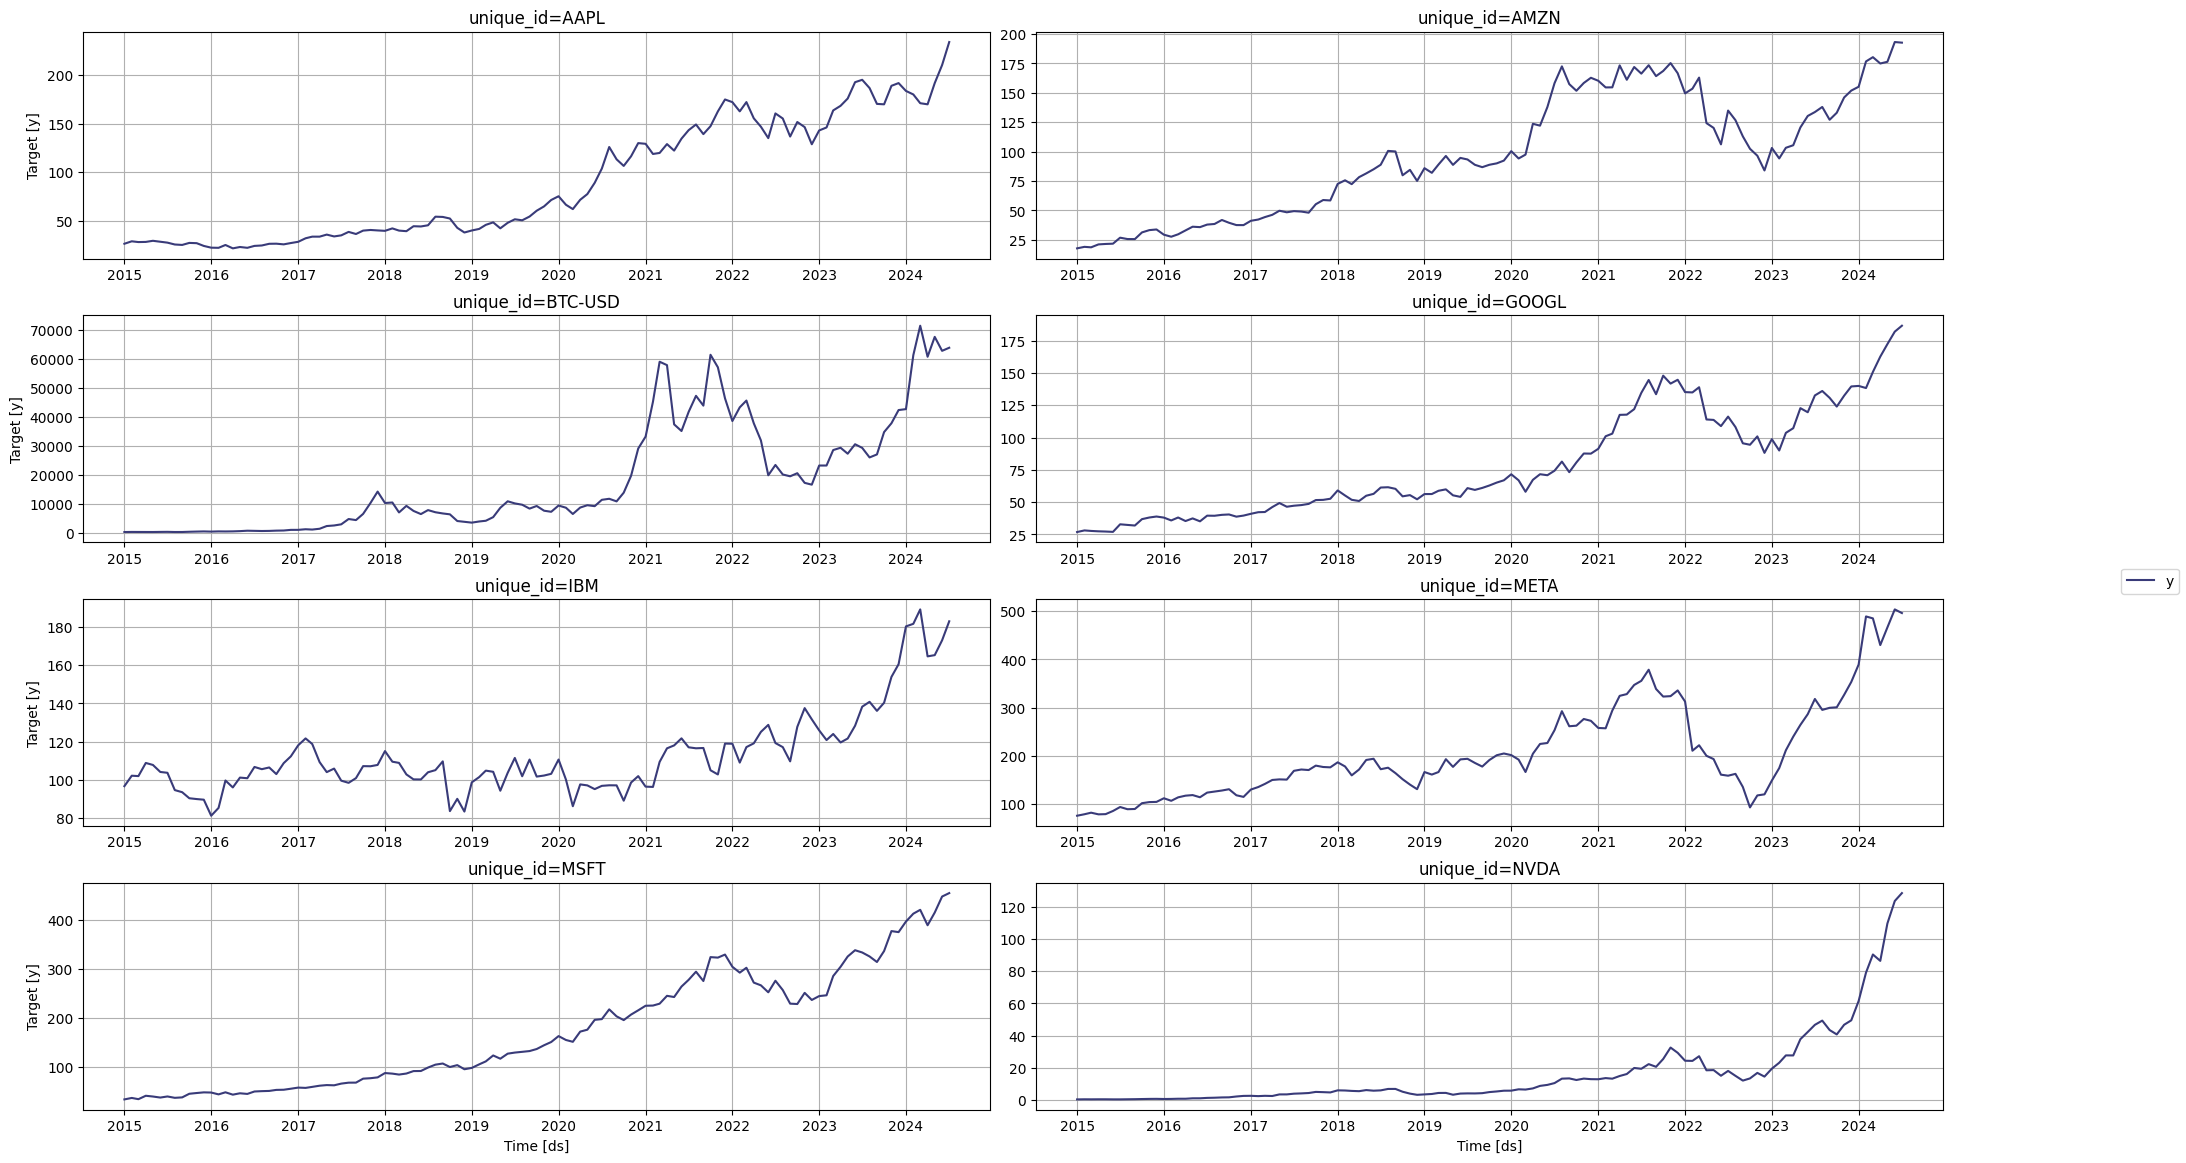

In [222]:
StatsForecast.plot(Y_df, plot_random = False)

In [223]:
season_length = 12
models = [
    AutoARIMA(season_length=season_length)
]

# Instantiate StatsForecast class with models, data frequency ('MS' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='MS',  # frequency of the data
    n_jobs=1  # number of jobs to run in parallel, -1 means using all processors
)

In [224]:
horizon = 3
levels = [99] 

fcst = sf.forecast(df=Y_df, h = horizon, level = levels, fitted = True)
fcst = fcst.reset_index()
fcst.head()


,unique_id,ds,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99
0,AAPL,2024-08-01,237.293457,215.313263,259.273651
1,AAPL,2024-09-01,234.550751,200.112274,268.989227
2,AAPL,2024-10-01,234.477203,191.015854,277.938538
3,AMZN,2024-08-01,192.720001,168.518173,216.921829
4,AMZN,2024-09-01,192.720001,158.493439,226.946564


In [225]:
insample_forecasts = sf.forecast_fitted_values().reset_index()
insample_forecasts.head()

,unique_id,ds,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99
0,AAPL,2015-01-01,26.149809,26.123659,4.143472,48.103848
1,AAPL,2015-02-01,28.671946,26.236805,4.256618,48.216991
2,AAPL,2015-03-01,27.882061,29.151358,7.171170,51.131546
3,AAPL,2015-04-01,28.043398,27.622898,5.642711,49.603085
4,AAPL,2015-05-01,29.192917,28.146397,6.166209,50.126583


In [226]:
anomalies = insample_forecasts.loc[(insample_forecasts['y'] >= insample_forecasts['AutoARIMA-hi-99']) | (insample_forecasts['y'] <= insample_forecasts['AutoARIMA-lo-99'])]
anomalies.head()

,unique_id,ds,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99
90,AAPL,2022-07-01,160.691971,133.947464,111.967285,155.927658
178,AMZN,2020-04-01,123.699997,97.486000,73.284164,121.687836
202,AMZN,2022-04-01,124.281502,162.997498,138.795670,187.199326
205,AMZN,2022-07-01,134.949997,106.209999,82.008163,130.411835
306,BTC-USD,2021-05-01,37332.855469,57139.464844,44605.960938,69672.968750


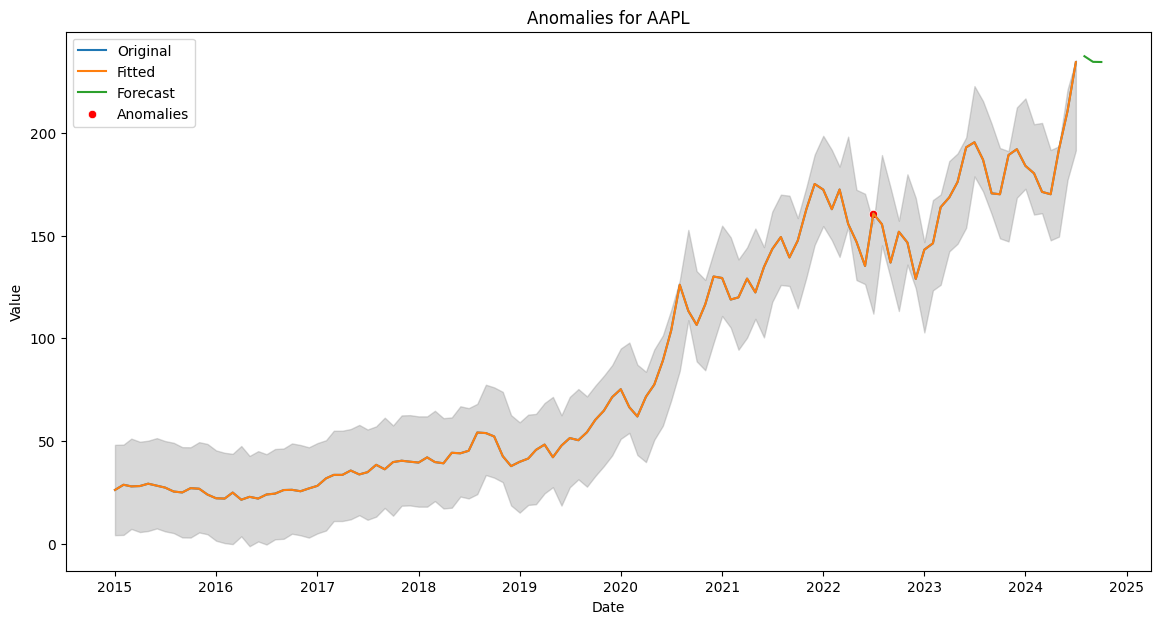

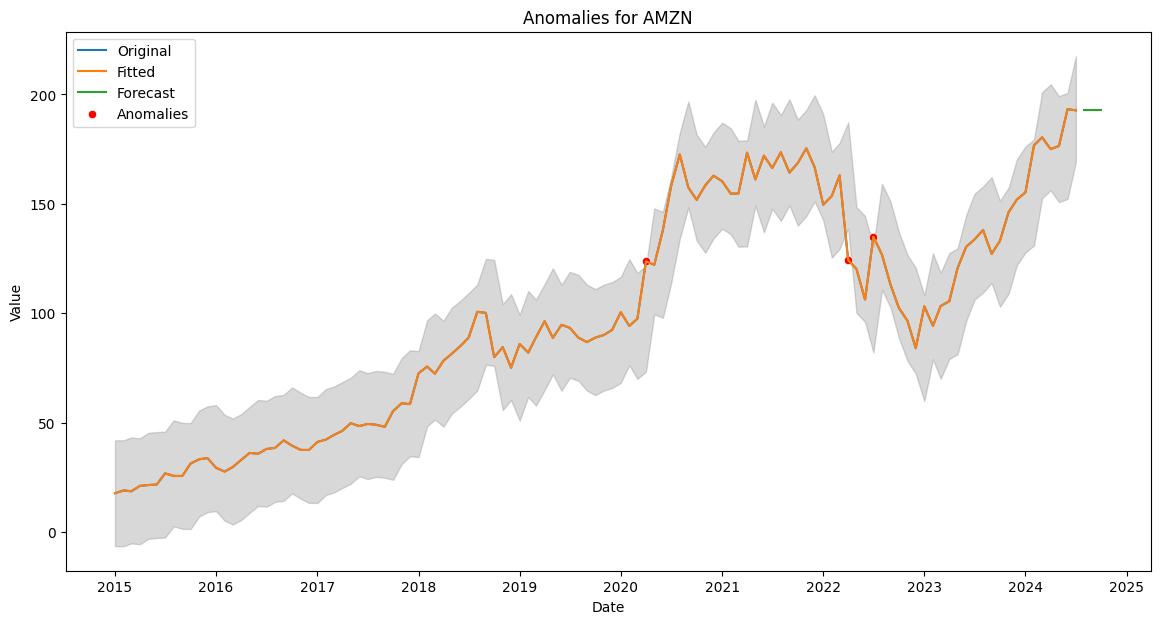

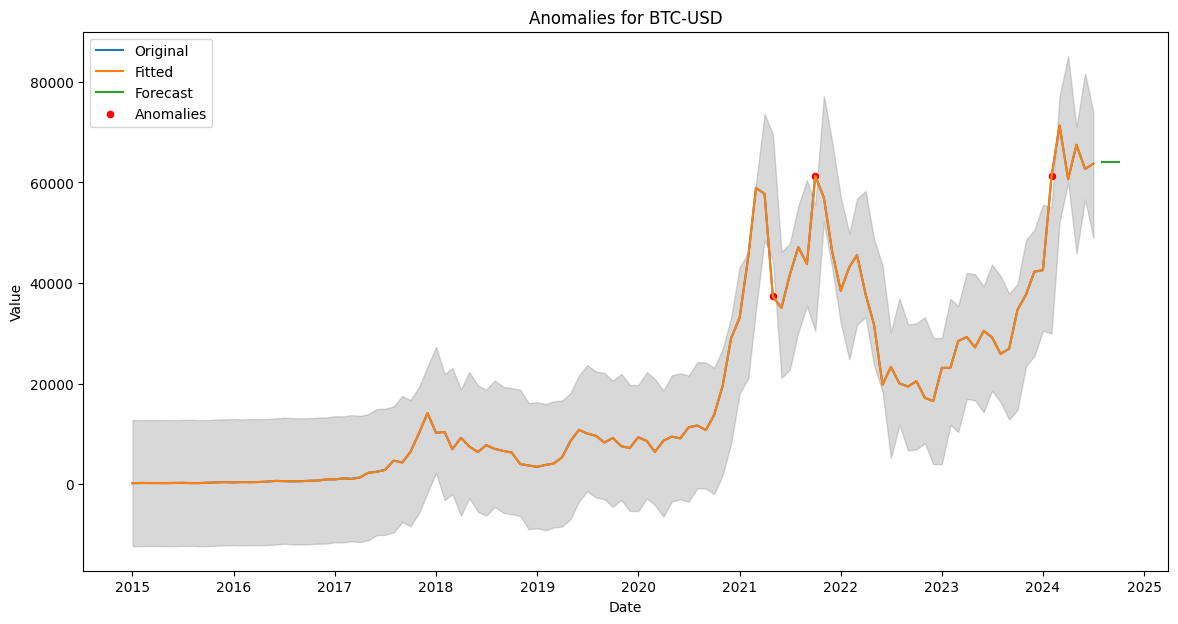

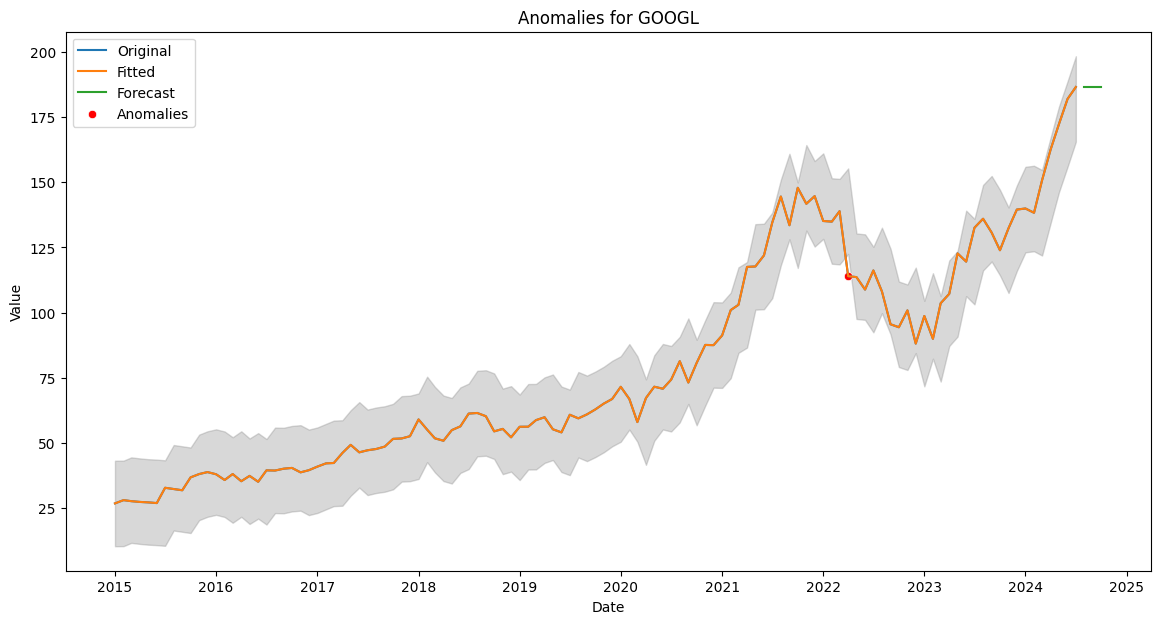

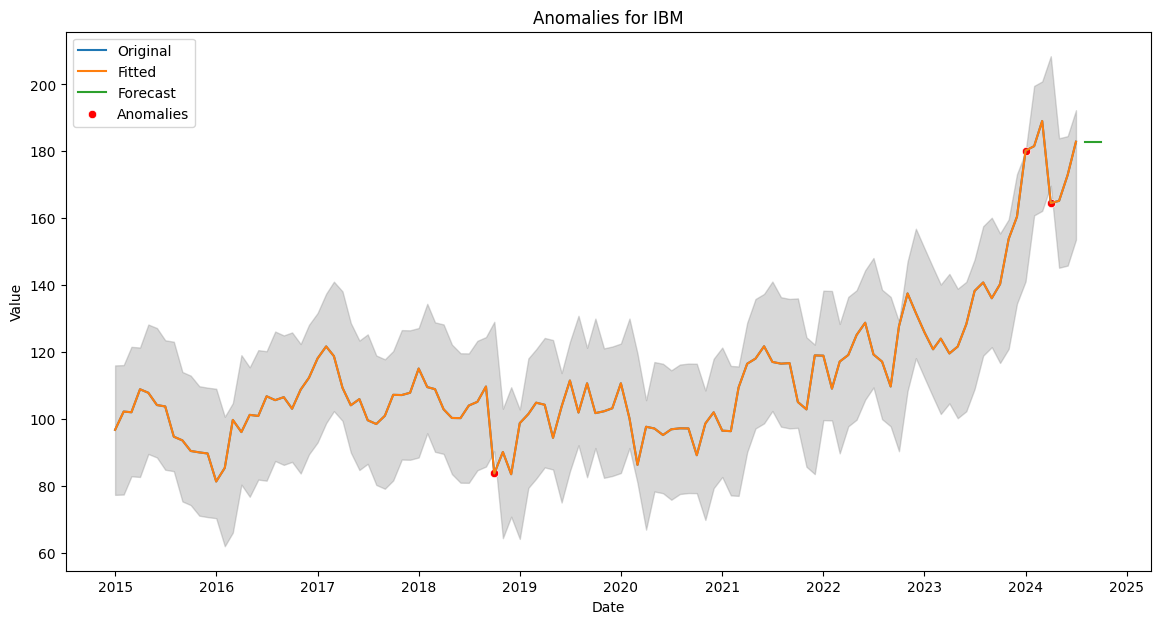

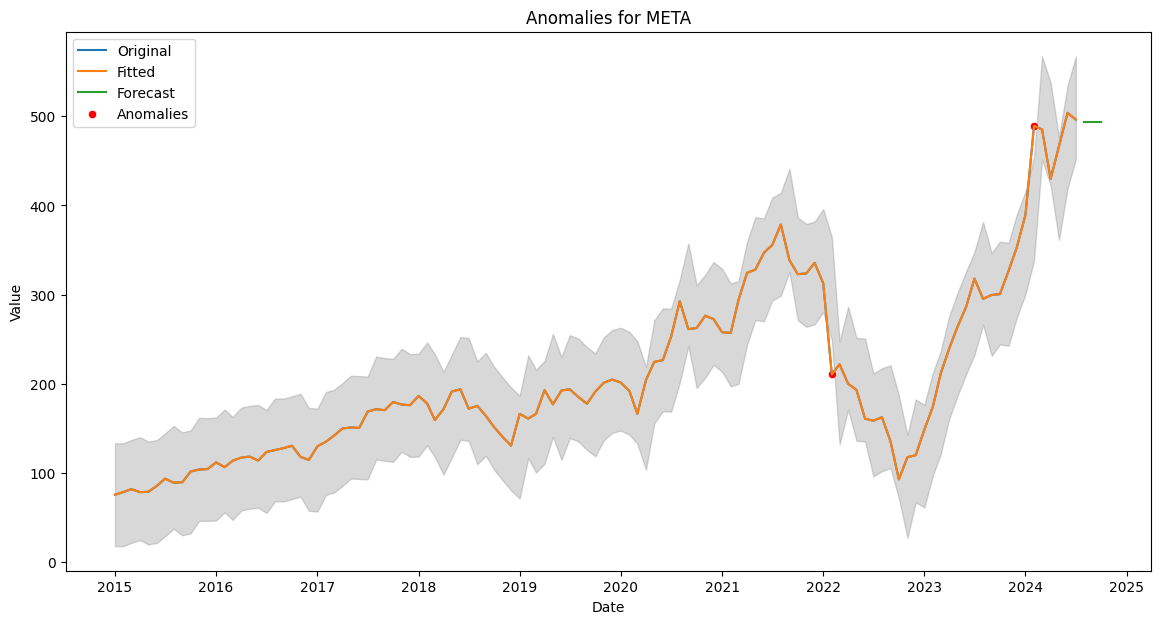

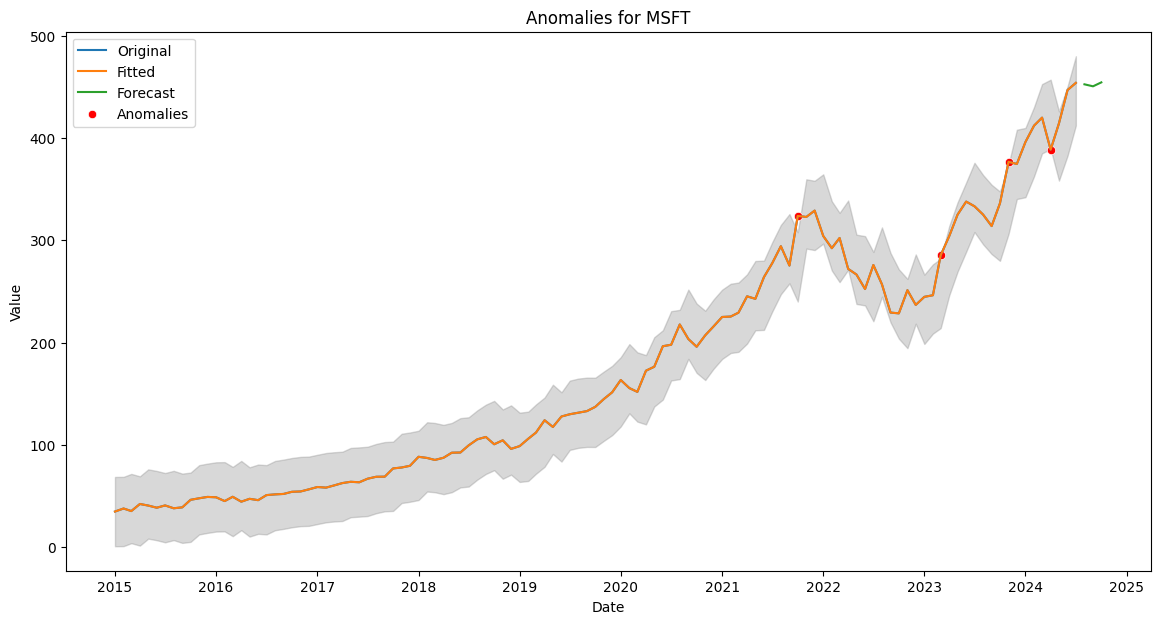

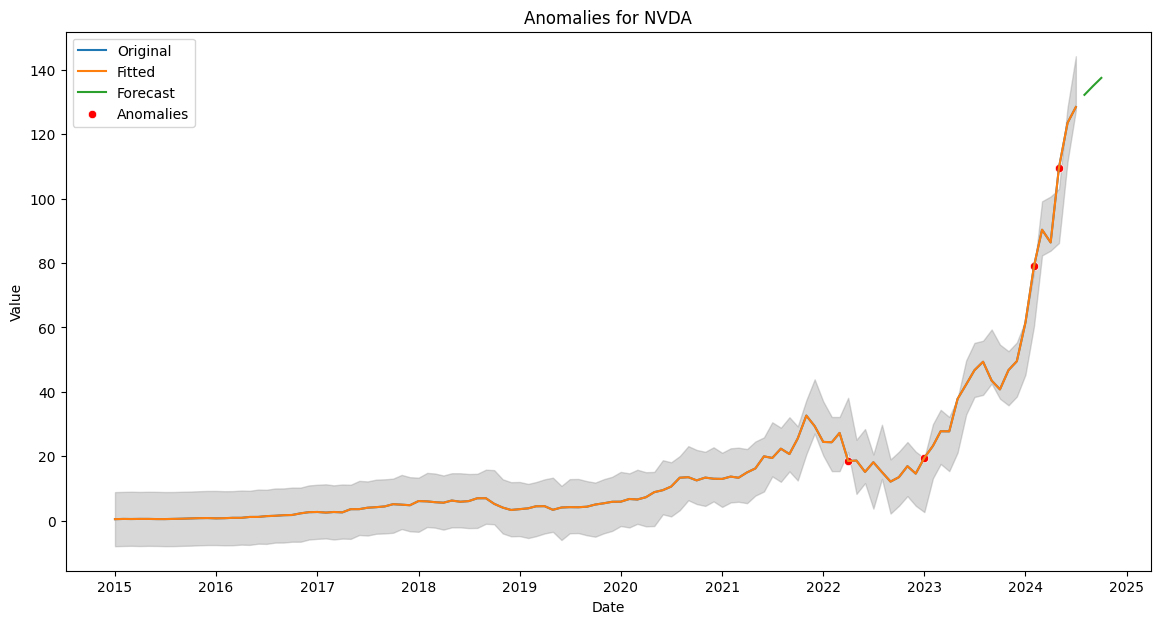

In [227]:
# Graficar resultados
unique_ids = Y_df['unique_id'].unique()

for unique_id in unique_ids:
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Datos originales
    sns.lineplot(data=Y_df[Y_df['unique_id'] == unique_id], x='ds', y='y', label='Original', ax=ax)
    
    # Valores ajustados y predicciones
    sns.lineplot(data=insample_forecasts[insample_forecasts['unique_id'] == unique_id], x='ds', y='y', label='Fitted', ax=ax)
    sns.lineplot(data=fcst[fcst['unique_id'] == unique_id], x='ds', y='AutoARIMA', label='Forecast', ax=ax)
    
    # Intervalos de confianza
    ax.fill_between(
        insample_forecasts[insample_forecasts['unique_id'] == unique_id]['ds'],
        insample_forecasts[insample_forecasts['unique_id'] == unique_id]['AutoARIMA-lo-99'],
        insample_forecasts[insample_forecasts['unique_id'] == unique_id]['AutoARIMA-hi-99'],
        color='gray', alpha=0.3
    )
    
    # Marcar anomalías
    anomaly_data = anomalies[anomalies['unique_id'] == unique_id]
    sns.scatterplot(data=anomaly_data, x='ds', y='y', color='red', label='Anomalies', ax=ax)
    
    ax.set_title(f'Anomalies for {unique_id}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    plt.legend()
    plt.show()